In [1]:
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, validation_curve, learning_curve, GridSearchCV
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from yellowbrick.model_selection import ValidationCurve, LearningCurve


In [2]:


%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')



In [3]:
house_sales = pd.read_csv('kc_house_data.csv')
house_sales = house_sales.drop(
    ['id', 'zipcode', 'lat', 'long', 'date'], axis=1)
house_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  sqft_living15  21613 non-null  int64  
 15  sqft_lot15     21613 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 2.6 MB


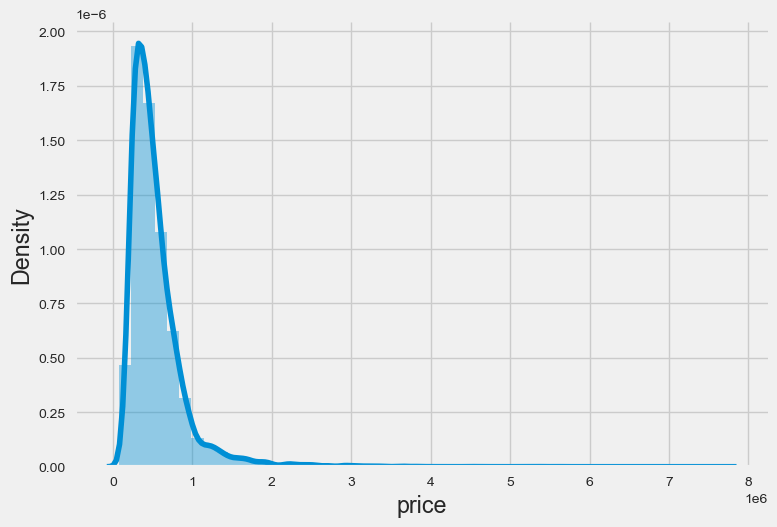

In [4]:
sns.distplot(house_sales.price)
sns.despine()
plt.tight_layout();

In [5]:
X_all = house_sales.drop('price', axis=1)
y = np.log(house_sales.price)


In [6]:


mi_reg = pd.Series(mutual_info_regression(X_all, y),
                   index=X_all.columns).sort_values(ascending=False)
mi_reg



sqft_living      0.346128
grade            0.343673
sqft_living15    0.272945
sqft_above       0.259011
bathrooms        0.204914
sqft_lot15       0.084432
bedrooms         0.082230
yr_built         0.075508
floors           0.072798
sqft_basement    0.069846
sqft_lot         0.061647
view             0.058684
condition        0.012828
waterfront       0.011423
yr_renovated     0.008773
dtype: float64

In [7]:
X = X_all.loc[:, mi_reg.iloc[:10].index]

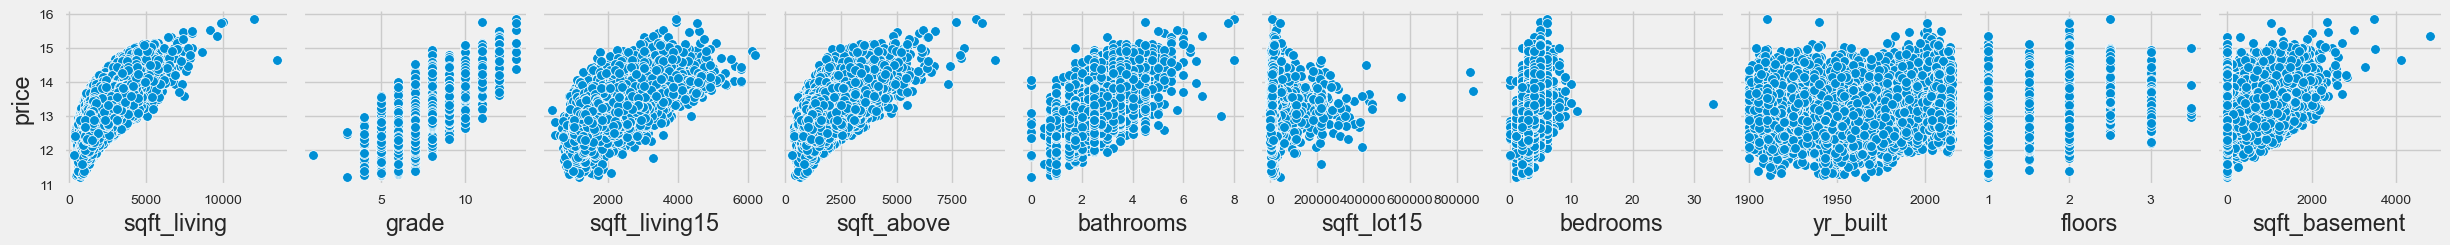

In [8]:
g = sns.pairplot(X.assign(price=y), y_vars=['price'], x_vars=X.columns)
sns.despine();

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sqft_living    21613 non-null  int64  
 1   grade          21613 non-null  int64  
 2   sqft_living15  21613 non-null  int64  
 3   sqft_above     21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_lot15     21613 non-null  int64  
 6   bedrooms       21613 non-null  int64  
 7   yr_built       21613 non-null  int64  
 8   floors         21613 non-null  float64
 9   sqft_basement  21613 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.6 MB


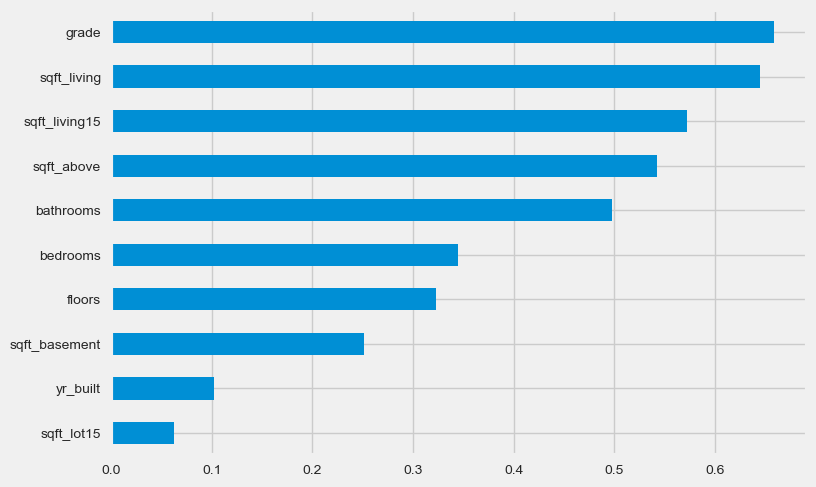

In [10]:
correl = X.apply(lambda x: spearmanr(x, y)[0])
correl.sort_values().plot.barh();

In [11]:
X_scaled = scale(X)

In [12]:
model = KNeighborsRegressor()
model.fit(X=X_scaled, y=y)

KNeighborsRegressor()

In [13]:
y_pred = model.predict(X_scaled)

In [14]:


from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error, 
                             median_absolute_error, 
                             explained_variance_score, 
                             r2_score)



In [15]:
error = (y - y_pred).rename('Prediction Errors')

In [16]:


scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)



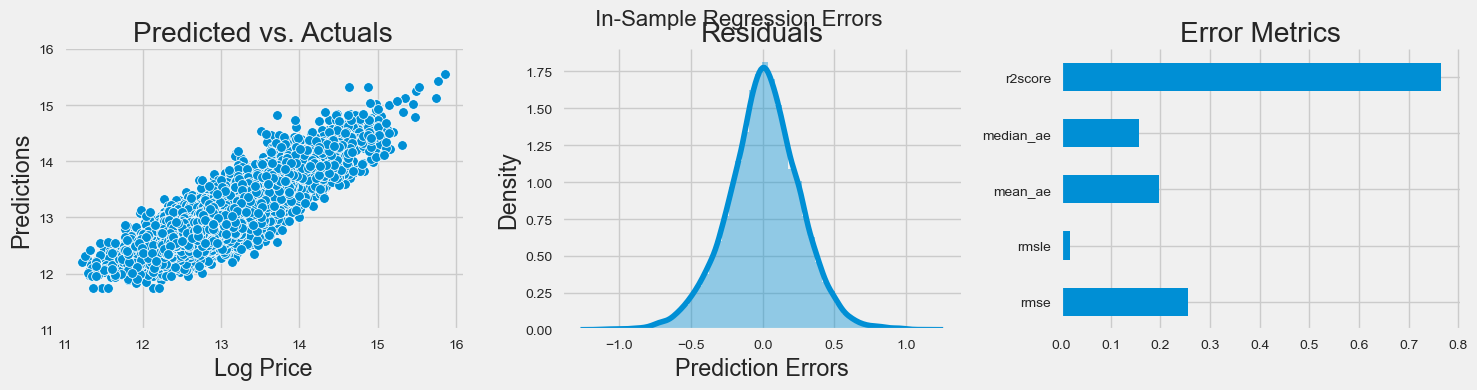

In [17]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
axes[0].set_title('Predicted vs. Actuals')
sns.distplot(error, ax=axes[1])
axes[1].set_title('Residuals')
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('In-Sample Regression Errors', fontsize=16)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.88)
